In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from Environment import Environment
from Agent import Agent
import numpy as np
from plot import plot
from Display import disp
from termcolor import colored
from tqdm import tqdm
from math import log, exp
import tensorflow as tf

In [40]:
def run(episodes: int, iterations: int, env=None, agent=None, method="Episods_Iterations"):
    sigma = 1e-2
    if env == None:
        env = Environment(num_of_antennas=8, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
    

    num_of_actions1 = env.M1 + env.M2 
    num_of_actions2 = len(env.Users) * env.N + env.num_of_users - 1


    # if agent == None:
    agent1 = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                    env=env, n_actions=num_of_actions1,
                    noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256, beamforming=False)
    
    agent2 = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                    env=env, n_actions=num_of_actions2,
                    noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256, beamforming=True)


    num_of_episodes = episodes
    num_of_iterations = iterations

    score_history = np.zeros((num_of_episodes,))
    rewards = np.zeros((num_of_episodes, num_of_iterations))
    sumrate = np.zeros((num_of_episodes, num_of_iterations))
    U1_SINR = np.zeros((num_of_episodes, num_of_iterations))
    U2_SINR = np.zeros((num_of_episodes, num_of_iterations))

    Old_Avg = 0
    # obs = env.State()

    for ep in range(num_of_episodes):
        score = 0
        obs = env.State()

        if ep < num_of_episodes / 5:
            agent1.noise = 0.5
            agent2.noise = 0.5
        elif ep < num_of_episodes * 2 / 5:
            agent1.noise = 0.4
            agent2.noise = 0.4
        elif ep < num_of_episodes * 3 / 5:
            agent1.noise = 0.3
            agent2.noise = 0.3

        elif ep < num_of_episodes * 4 / 5:
            agent1.noise = 0.2
            agent2.noise = 0.2
        elif ep < num_of_episodes - 5 :
            agent1.noise = 0.1
            agent2.noise = 0.1
        else:
            agent1.noise = 0.001
            agent2.noise = 0.001


        # agent.noise = (0.5) / (ep + 1) 
        for iter in range(num_of_iterations):
            
            action1 = agent1.choose_action(obs)
            action2 = agent2.choose_action(obs)

            action = tf.concat([action1, action2], axis=0)

            new_state, reward, sumrate[ep][iter], SINRs = env.Step(action)
 
            agent1.remember(obs, action1, reward, new_state)
            agent2.remember(obs, action2, reward, new_state)
                
            agent1.learn()
            agent2.learn()


            obs = new_state
            score += reward
            rewards[ep][iter] = reward

            U1_SINR[ep][iter] = SINRs[0]
            U2_SINR[ep][iter] = SINRs[1]

        # agent.learn()
        score = score / num_of_iterations
        score_history[ep] = score
        New_Avg = score_history[:ep + 1].mean()

        disp(episod=ep, score=score, score_history=score_history,
                New_Avg=New_Avg, Old_Avg=Old_Avg, SINRs=SINRs, sumrate=sumrate[ep][iter])
        
        ac = np.array(action)
        power_noise = np.array(agent2.power_noise)
        print("Power split factor = "+ colored(f"{ac[-1 : ][0]: <5.2}", "blue") +
            "| Power noise = " + colored(f"{power_noise[-1]: <5.2}", "blue") )
        
        # print(agent.memory.buffer_counter)

        # obs = env.Reset()
        Old_Avg = New_Avg

    plot(score_history=score_history, sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)
    
    return agent1, agent2
    

In [59]:
def run3(iterations: int, env=None, agent=None, method="Iterations_Only"):
    sigma = 1e-2

    if env == None : 
        env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
        
    num_of_actions1 = env.M1 + env.M2 
    num_of_actions2 = len(env.Users) * env.N + env.num_of_users - 1

    if agent == None :
        agent1 = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                        env=env, n_actions=num_of_actions1,
                        noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256, beamforming=False)
        
        agent2 = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                        env=env, n_actions=num_of_actions2,
                        noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256, beamforming=True)

    num_of_iterations = iterations
    rewards = np.zeros((1, num_of_iterations))
    sumrate = np.zeros((1, num_of_iterations))
    U1_SINR = np.zeros((1, num_of_iterations))
    U2_SINR = np.zeros((1, num_of_iterations))

    obs = env.State()

    for iter in tqdm(range(num_of_iterations), desc= colored("Agent is Learning :) ", "green"), ncols=123, colour= "red"):

        agent1.noise = (0.5) * exp(-(iter / (num_of_iterations/2)) ** 2)
        agent2.noise = (0.5) * exp(-(iter / (num_of_iterations/2)) ** 2)
    

        action1 = agent1.choose_action(obs)
        new_state1, reward1, _, _ = env.Step(action1, beamforming=False, double=True)
        agent1.remember(obs, action1, reward1, new_state1)

        action2 = agent2.choose_action(obs)
        new_state2, reward2, _, _ = env.Step(action2, beamforming=True, double=True)
        agent2.remember(obs, action2, reward2, new_state2)
        
        action = tf.concat([action1, action2], axis=0)
        new_state, reward, sumrate[0][iter], SINRs = env.Step(action, beamforming=True, double=False)

        agent1.learn()
        agent2.learn()

        obs = new_state
        rewards[0][iter] = reward
        U1_SINR[0][iter] = SINRs[0]
        U2_SINR[0][iter] = SINRs[1]

    plot(score_history=np.array([1]), sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)

    return agent1, agent2


In [56]:
def run2(iterations: int, env=None, agent=None, method="Iterations_Only"):
    sigma = 1e-2

    if env == None : 
        env = Environment(num_of_antennas=10, num_of_irs1=10, num_of_irs2=10,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

        U1 = env.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=False, los_to_irs1=False,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

        U2 = env.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
        

    num_of_actions = env.M1 + env.M2 + len(env.Users) * env.N + env.num_of_users - 1

    if agent == None :
        agent = Agent(num_states=env.num_of_users, bound=1, batch_size=128, max_size=100000,
                        env=env, n_actions=num_of_actions,
                        noise=0.02, alpha=0.0002, beta=0.0004, fc1=512, fc2=256, beamforming=True)


    num_of_iterations = iterations
    rewards = np.zeros((1, num_of_iterations))
    sumrate = np.zeros((1, num_of_iterations))
    U1_SINR = np.zeros((1, num_of_iterations))
    U2_SINR = np.zeros((1, num_of_iterations))

    obs = env.State()

    for iter in tqdm(range(num_of_iterations), desc= colored("Agent is Learning :) ", "green"), ncols=123, colour= "red"):

        agent.noise = (0.5) * exp(-(iter / (num_of_iterations/2)) ** 2)
    

        action = agent.choose_action(obs)

        new_state, reward, sumrate[0][iter], SINRs = env.Step(action, beamforming=True, double=False)
        # if reward != 0 : 
        agent.remember(obs, action, reward, new_state)
            
        agent.learn()
        obs = new_state
        rewards[0][iter] = reward
        U1_SINR[0][iter] = SINRs[0]
        U2_SINR[0][iter] = SINRs[1]

    plot(score_history=np.array([1]), sumrate=sumrate,
            u1_sinr=U1_SINR, u2_sinr=U2_SINR, mean=False,
            title=f"N = {env.N}, M1 = {env.M1}, M2 = {env.M2}", method=method)

    return agent


In [57]:
# Construct 2 equivalent environment
sigma = 1e-2
env1 = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

U11 = env1.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

U21 = env1.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)
#-------------------------------------------------------------------------------------------------------

env2 = Environment(num_of_antennas=5, num_of_irs1=5, num_of_irs2=5,
                            path_loss_exponent=2, irs1_to_antenna=20,
                            irs2_to_antenna=30, irs1_to_irs2=40, transmitted_power=1)

U12 = env2.CreateUser(distance_to_antenna=50, distance_to_irs1=50, distance_to_irs2=30,
                            noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                            los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

U22 = env2.CreateUser(distance_to_antenna=60, distance_to_irs1=40, distance_to_irs2=20,
                    noise_var=sigma**2, los_to_antenna=True, los_to_irs1=True,
                    los_to_irs2=True, sinr_threshold=3, penalty=0, allocated_power=0.5, weight=1)

env2.Hs1 = env1.Hs1
env2.Hs2 = env1.Hs2
env2.H12 = env1.H12
env2.H21 = env1.H21
env2.Psi1 = env1.Psi1
env2.Psi2 = env1.Psi2

U12.h1u = U11.h1u
U12.hsu = U11.hsu
U12.h2u = U11.h2u
U12.w = U11.w

U22.h1u = U21.h1u
U22.hsu = U21.hsu
U22.h2u = U21.h2u
U22.w = U21.w

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 6000/6000 [02:11<00:00, 45.63it/s]


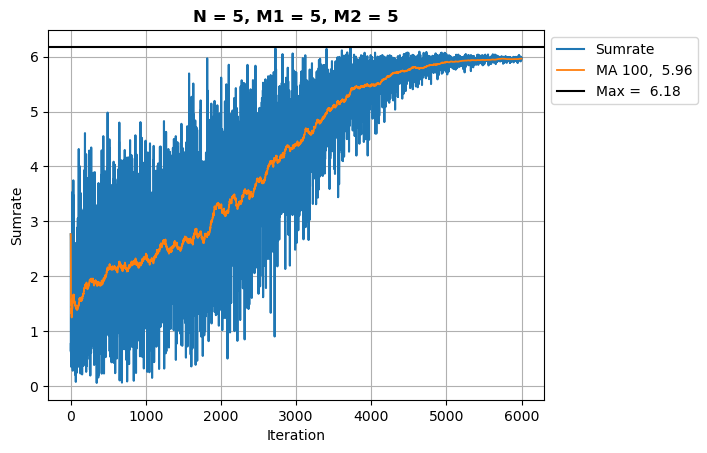

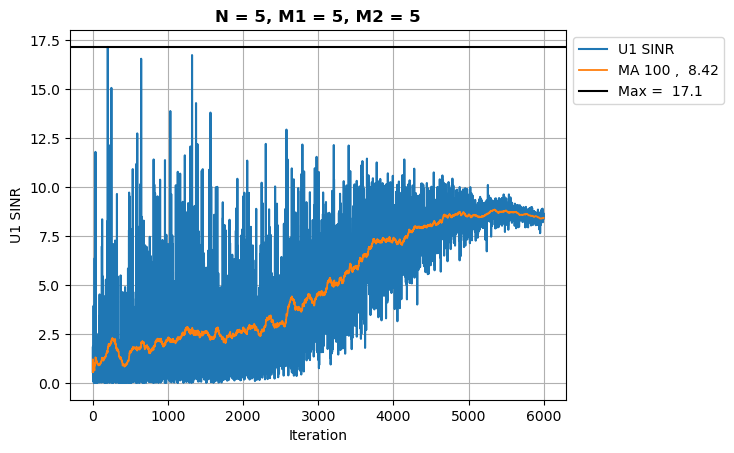

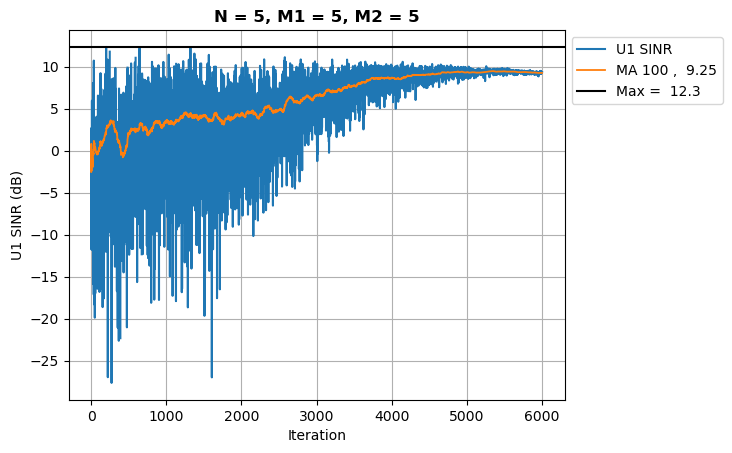

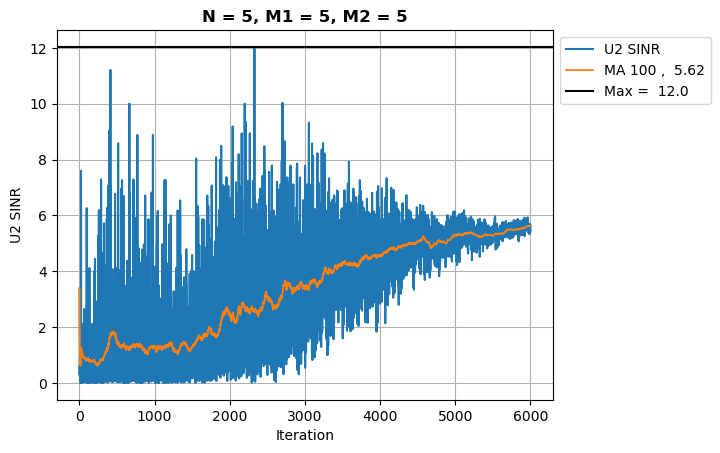

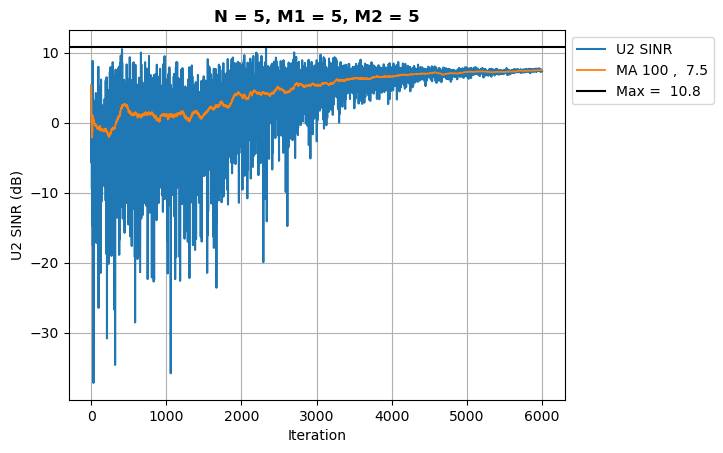

In [58]:
# agent 2 is learning
agnt1 , agnt2 = run3(6000, env=env1)

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 6000/6000 [03:03<00:00, 32.65it/s]


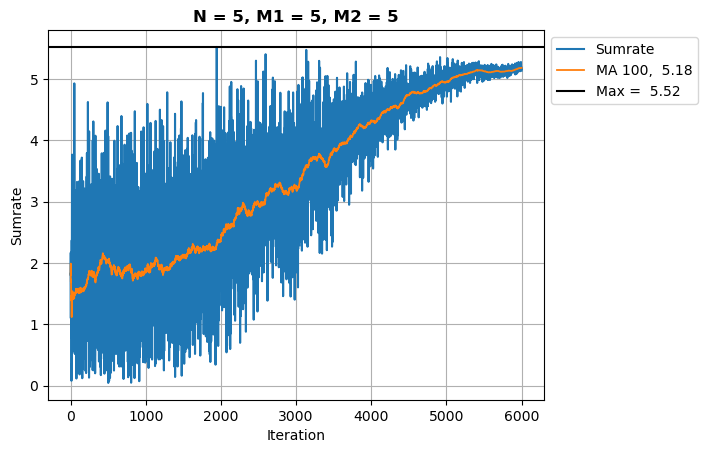

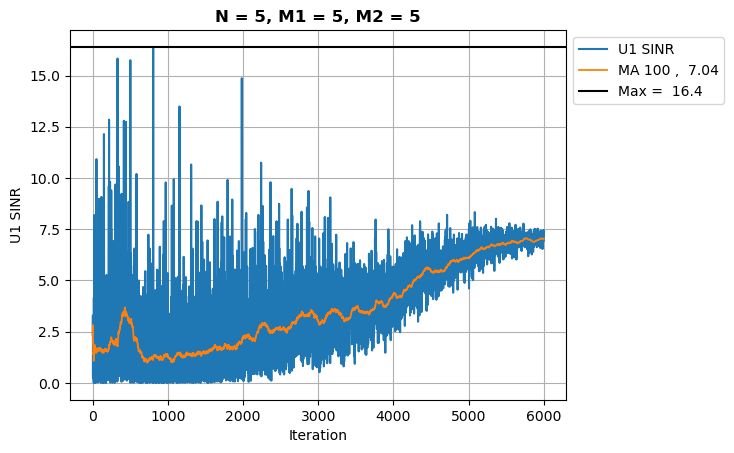

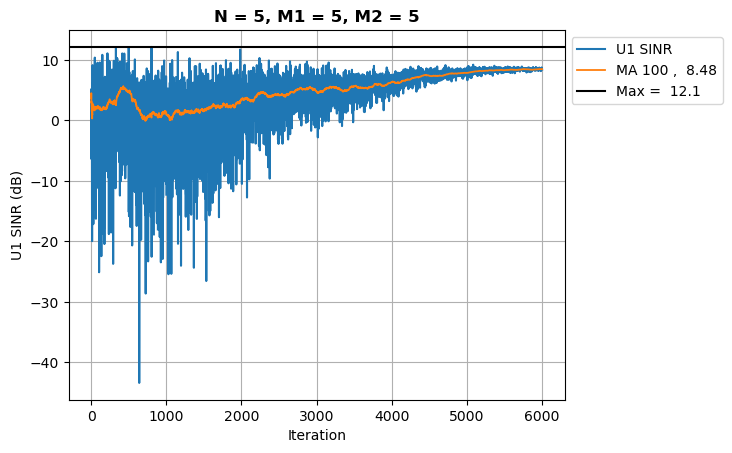

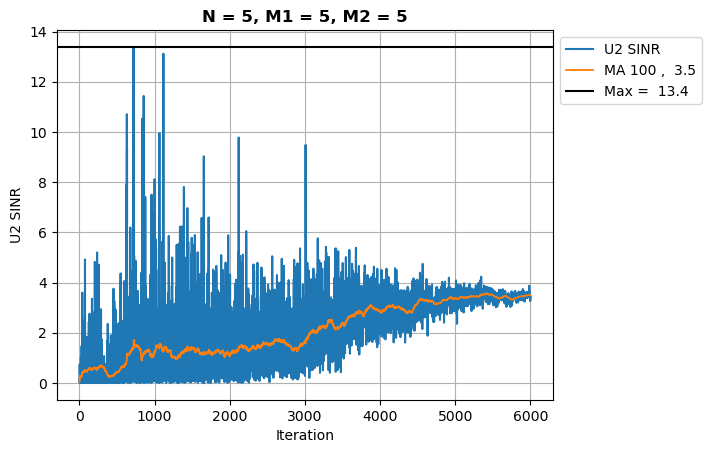

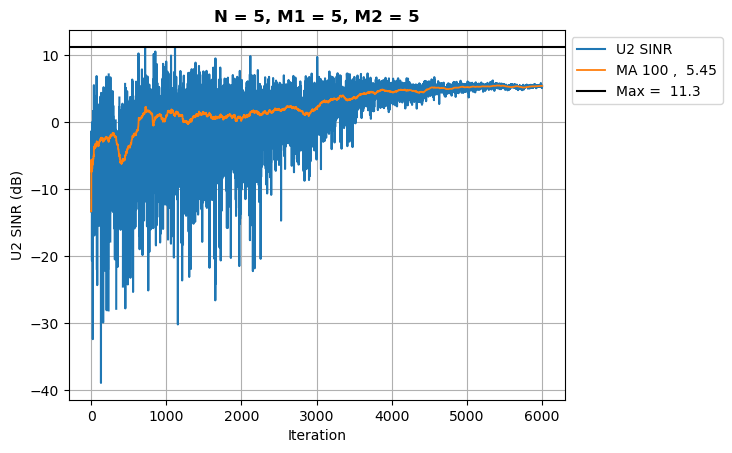

In [60]:
# both agents are learning
agnt11 , agnt21 = run3(6000, env=env2)

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 6000/6000 [01:53<00:00, 52.83it/s]


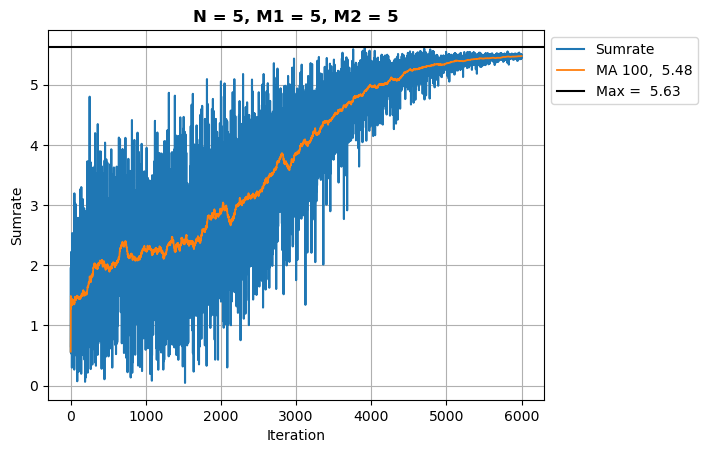

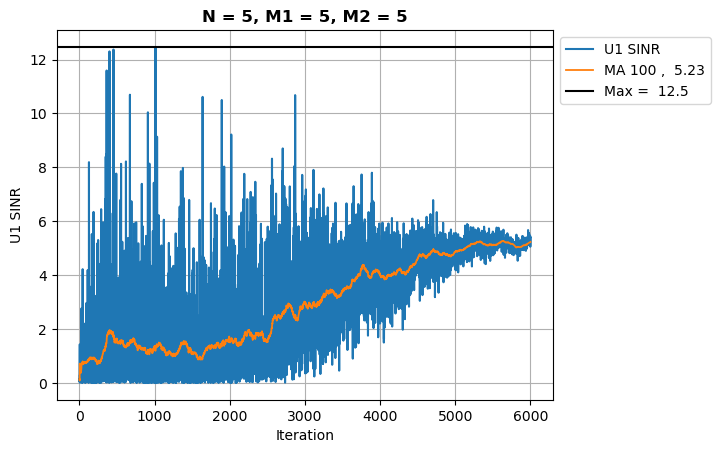

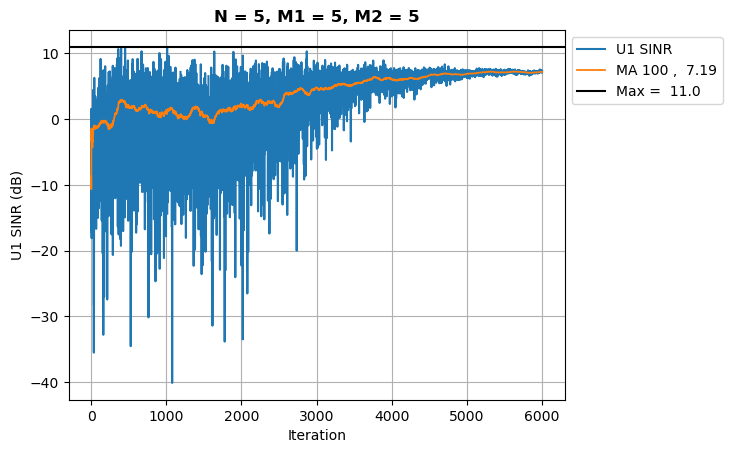

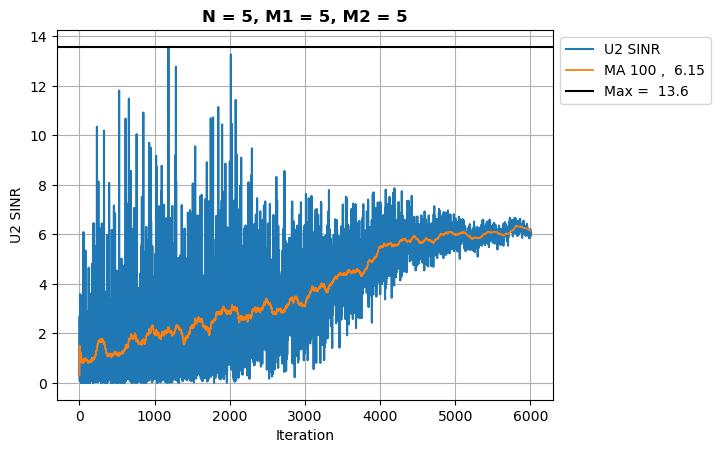

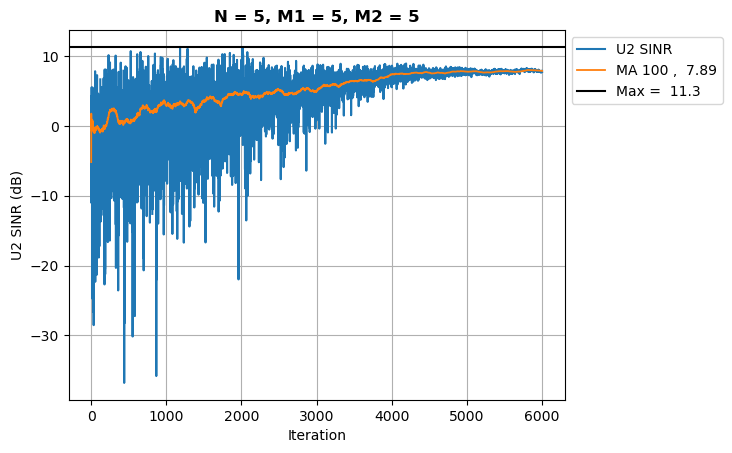

In [8]:
agent1 = run2(6000, env=env2)

Agent is Learning :) : 100%|███████████████████████████████████████████████████████████| 4000/4000 [02:24<00:00, 27.63it/s]


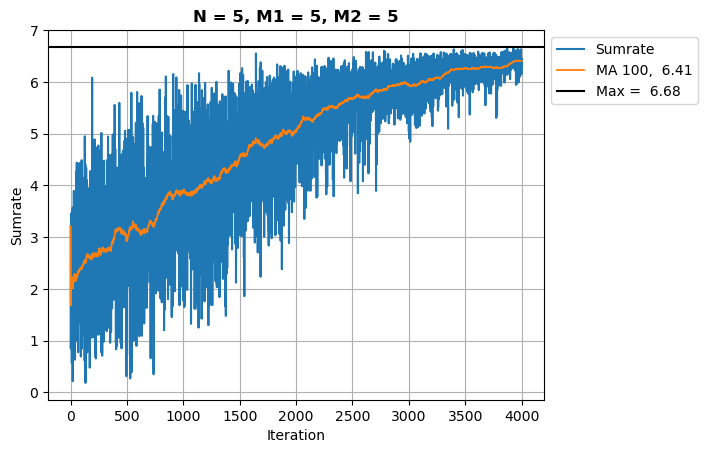

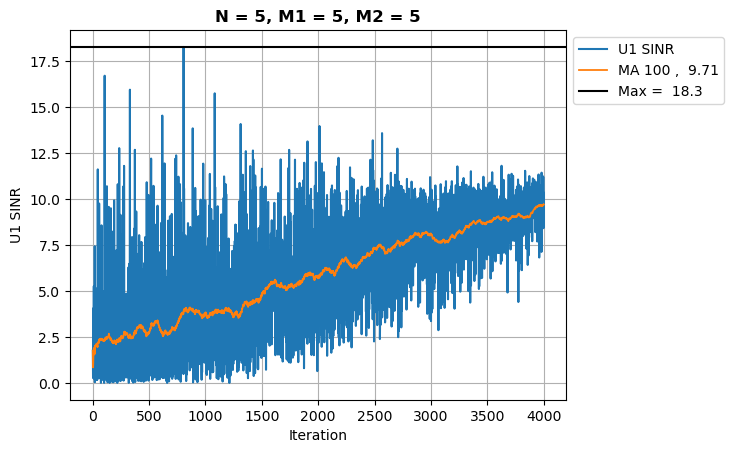

/mnt/c/Users/danes/Desktop/IRS-Project/src/plot.py:88: RuntimeWarning: divide by zero encountered in log10
  np.log10(u1_sinr), linewidth=1.5, label='U1 SINR')


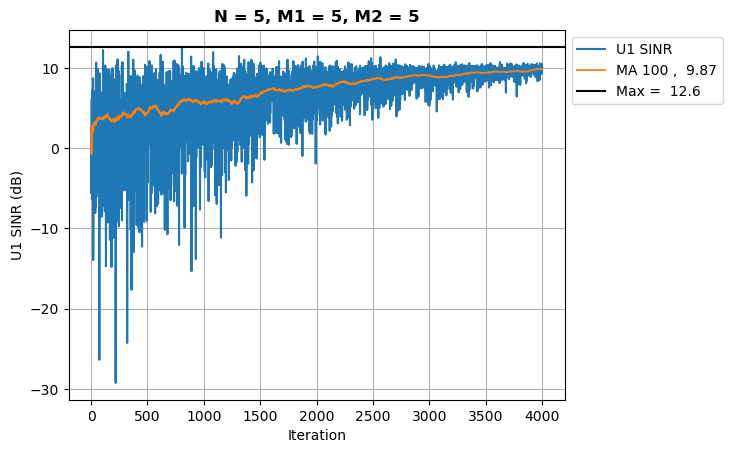

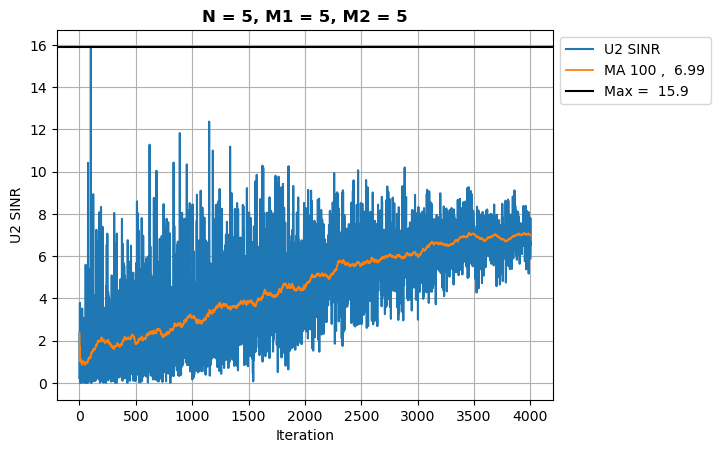

/mnt/c/Users/danes/Desktop/IRS-Project/src/plot.py:144: RuntimeWarning: divide by zero encountered in log10
  np.log10(u2_sinr), linewidth=1.5, label='U2 SINR')


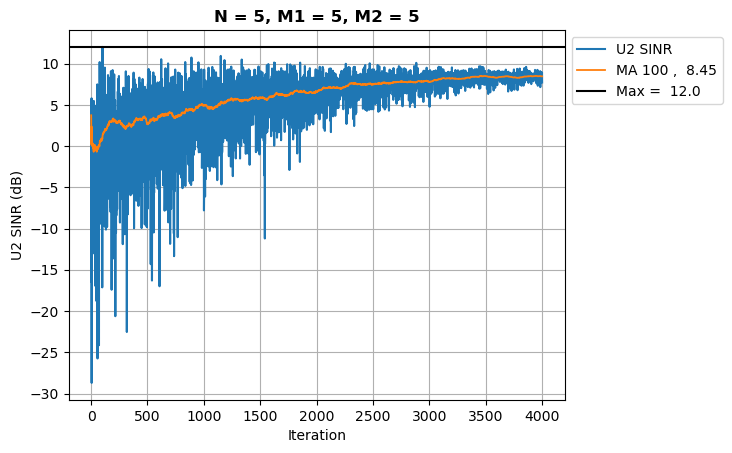

In [14]:
agent2 = run2(4000, env=env1, agent=agent1)

In [ ]:
print(np.diag(np.angle(env.Psi1, deg=True)))
print("************************************************************************************")
print(np.diag(np.angle(env.Psi2, deg=True)))
print("************************************************************************************")
print(max(sumrate.reshape(num_of_episodes*num_of_iterations,)))

[  5.80351911 102.90995479 123.30667377  60.71778774  78.84238601]
************************************************************************************
[1.80000000e+02 1.80000000e+02 1.79999979e+02 1.78838679e+02
 6.44566103e-04]
************************************************************************************
6.4951752893006685


In [18]:
print(np.linalg.norm(U11.w)**2 + np.linalg.norm(U21.w)**2)
print(U11.allocated_power , U21.allocated_power)

1.0
0.514385998249054 0.48561400175094604


In [48]:
print(env1.SINR, env1.SumRate)
print(env2.SINR, env2.SumRate)

[20.180652990053186, 13.479671442466971] 8.260632124101356
[18.405552395336056, 9.85741100653092] 7.719005818705186
